In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN.PINN import *
from NN_library.PINN.train_dual_PINN import *
%load_ext autoreload
%autoreload 2

Using device: cuda


In [3]:
data = dataset_Sobol(12, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**12)

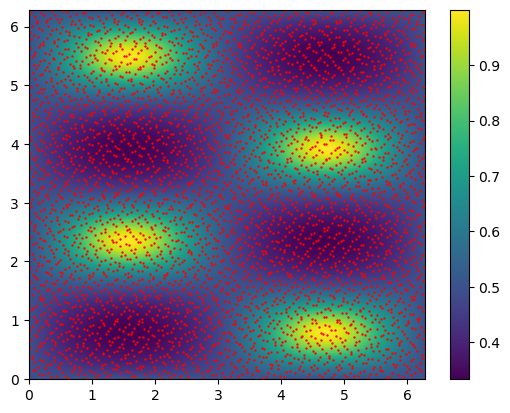

In [4]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
rot_mat = torch.tensor([[0, -1], [1, 0]], device=dev, dtype=torch.float)
H1 = torch.tensor([1, 0], device=dev, dtype=torch.float).view(1, 2) # macrogradient
H2 = torch.tensor([0, 1], device=dev, dtype=torch.float).view(1, 2) # macrogradient
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)
def a_function_inv(x,y):
    a = 1/(2+np.sin(x)*np.sin(2*y))
    return a
def A_inv(x):
    a = 1/((2+torch.sin(x[:,0])*torch.sin(2*x[:,1]))).view(-1,1,1)
    I = torch.eye(2, device=dev,).repeat(x.shape[0], 1, 1)
    A = a * I
    return A.to(dtype=torch.float)
Z = a_function_inv(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.5, c='r')

In [5]:
net_H1 = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_H1.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0005, 'epochs' : 5000, 'dev' : dev, 'name' : f'NN_library/PINN/PINN_dual_H1_{total_params}'}

Number of parameters: 1801


In [7]:
net_H1 = load_network(net_H1, args['name']+'_19999', args)
net_H1 = net_H1.to(dev)

In [7]:
losses_train, losses_val = train(net_H1, loaders, args, A_inv, H1)

Epoch: 0 mean train loss:  1.20234098e-01, mean val. rec. loss:  1.16469212e-01
Epoch: 1 mean train loss:  1.16314890e-01, mean val. rec. loss:  1.13545693e-01
Epoch: 2 mean train loss:  1.13396151e-01, mean val. rec. loss:  1.11181053e-01
Epoch: 3 mean train loss:  1.11027711e-01, mean val. rec. loss:  1.09259280e-01
Epoch: 4 mean train loss:  1.09116045e-01, mean val. rec. loss:  1.07700888e-01
Epoch: 5 mean train loss:  1.07559603e-01, mean val. rec. loss:  1.06439488e-01
Epoch: 6 mean train loss:  1.06299098e-01, mean val. rec. loss:  1.05413249e-01
Epoch: 7 mean train loss:  1.05277025e-01, mean val. rec. loss:  1.04565887e-01
Epoch: 8 mean train loss:  1.04428627e-01, mean val. rec. loss:  1.03848034e-01
Epoch: 9 mean train loss:  1.03713433e-01, mean val. rec. loss:  1.03216174e-01
Epoch: 10 mean train loss:  1.03083066e-01, mean val. rec. loss:  1.02634208e-01
Epoch: 11 mean train loss:  1.02500333e-01, mean val. rec. loss:  1.02072953e-01
Epoch: 12 mean train loss:  1.01939647

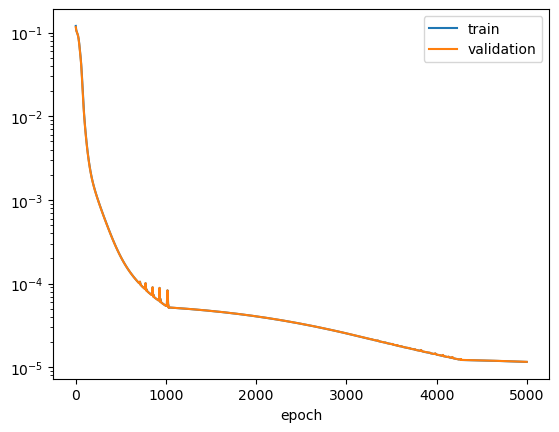

In [8]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [9]:
args = {'lr' : 0.0005, 'epochs' : 5000, 'dev' : dev, 'name' : 'NN_library/PINN/PINN_dual_scalar_H2'}
net_H2 = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_H2.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 1801


In [14]:
net_H2 = load_network(net_H2, args['name']+'_19999', args)
net_H2 = net_H2.to(dev)

In [10]:
losses_train, losses_val = train(net_H2, loaders, args, A_inv, H2)

Epoch: 0 mean train loss:  4.13084472e-02, mean val. rec. loss:  3.75161120e-02
Epoch: 1 mean train loss:  3.74808425e-02, mean val. rec. loss:  3.47249715e-02
Epoch: 2 mean train loss:  3.47005578e-02, mean val. rec. loss:  3.25094012e-02
Epoch: 3 mean train loss:  3.24897885e-02, mean val. rec. loss:  3.07364515e-02
Epoch: 4 mean train loss:  3.07177488e-02, mean val. rec. loss:  2.93095982e-02
Epoch: 5 mean train loss:  2.92966535e-02, mean val. rec. loss:  2.81464830e-02
Epoch: 6 mean train loss:  2.81350141e-02, mean val. rec. loss:  2.71786816e-02
Epoch: 7 mean train loss:  2.71686516e-02, mean val. rec. loss:  2.63507448e-02
Epoch: 8 mean train loss:  2.63421049e-02, mean val. rec. loss:  2.56213121e-02
Epoch: 9 mean train loss:  2.56129011e-02, mean val. rec. loss:  2.49616870e-02
Epoch: 10 mean train loss:  2.49538556e-02, mean val. rec. loss:  2.43534900e-02
Epoch: 11 mean train loss:  2.43476284e-02, mean val. rec. loss:  2.37863021e-02
Epoch: 12 mean train loss:  2.37813724

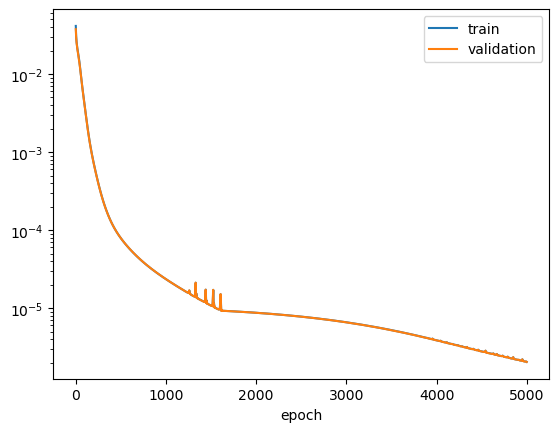

In [11]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [12]:
U1 = net_H1(grid_data)
U2 = net_H2(grid_data)

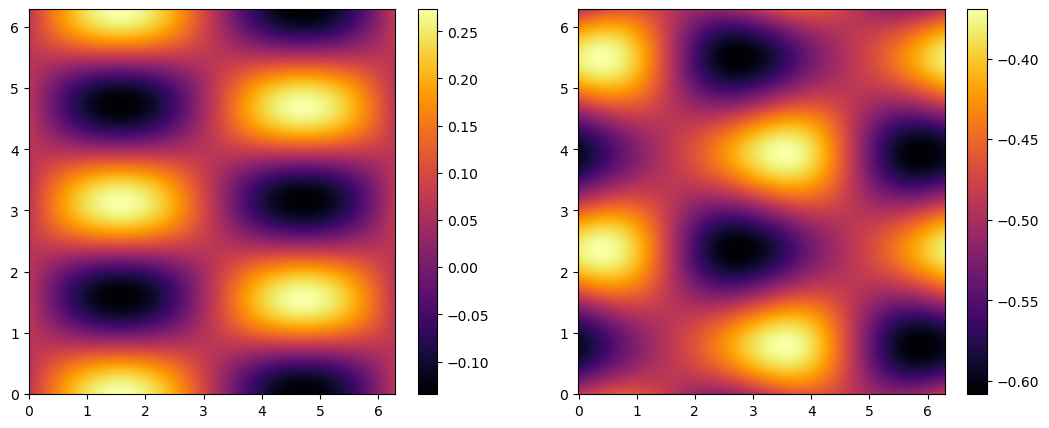

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N).detach().cpu(), cmap='inferno')
pos2 = axs[1].pcolormesh(XY[0], XY[1], U2.reshape(N, N).detach().cpu(), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
fig.colorbar(pos2, ax=axs[1])

In [14]:
error_1 = PDE_loss_dual(grid_data, net_H1, A_inv, H1).detach().cpu()
error_2 = PDE_loss_dual(grid_data, net_H2, A_inv, H2).detach().cpu()

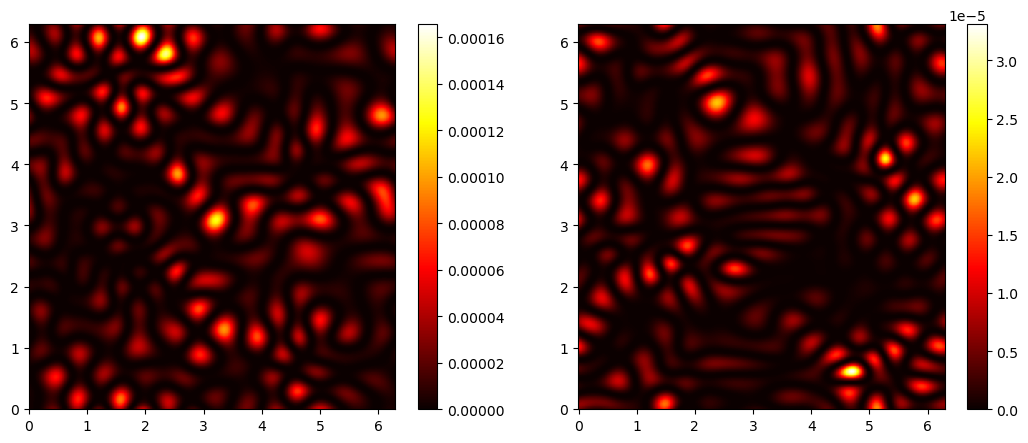

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], error_1.reshape(N, N), cmap='hot')
#axs[0].scatter(data[:,0], data[:,1], s=0.5, c='y')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.reshape(N, N), cmap='hot')
#axs[1].scatter(data[:,0], data[:,1], s=0.5, c='y')
fig.colorbar(pos2, ax=axs[1])

In [16]:
from matplotlib.tri import Triangulation
inputs = data[:].to(dev).requires_grad_(True)
T1 = net_H1(inputs)
T2 = net_H2(inputs)
dq1 = torch.autograd.grad(
            outputs=T1, inputs=inputs,
            grad_outputs=torch.ones_like(T1),
            create_graph=True, retain_graph=True
    )[0].detach()
dq2 = torch.autograd.grad(
            outputs=T2, inputs=inputs,
            grad_outputs=torch.ones_like(T2),
            create_graph=True, retain_graph=True
    )[0].detach()
curl_1 = torch.zeros_like(dq1)
curl_1[:,0] = -dq1[:,1]
curl_1[:,1] = dq1[:,0]
curl_2 = torch.zeros_like(dq2)
curl_2[:,0] = -dq2[:,1]
curl_2[:,1] = dq2[:,0]
triang = Triangulation(data[:,0], data[:,1])
n_elem = len(triang.triangles)

In [17]:
# Compute the B_h
B_h = np.zeros((2,2))
for i in range(n_elem):
    elem = triang.triangles[i]
    node_coords = data[elem]
    vector = node_coords[1:]-node_coords[:-1]
    vectors = np.column_stack((vector, [0, 0]))
    area = (1/2) * abs(np.cross(vectors[0], vectors[1])[-1])
    A_loc = A_inv(node_coords.to(dev))
    Q1 = A_loc @ (curl_1[elem] + H1).view(3,2,1)
    Q2 = A_loc @ (curl_2[elem] + H2).view(3,2,1)
    Q1_mean = Q1.mean(dim=0)
    Q2_mean = Q2.mean(dim=0)
    A_h_elem_1 = (area * Q1_mean).squeeze().detach().cpu().numpy()
    A_h_elem_2 = (area * Q2_mean).squeeze().detach().cpu().numpy()
    B_h[:,0] += A_h_elem_1
    B_h[:,1] += A_h_elem_2

A_bound = np.linalg.inv(B_h / L**2)
print(A_bound)

[[1.97437957e+00 9.92762937e-05]
 [7.94998009e-05 1.89548727e+00]]


In [18]:
np.save(f'bounds/A_l_NN_{total_params}.npy', A_bound)